In [1]:
%%bash
wget http://blob.c.epti.moe/comp7043/data.tar.gz  # college network only
tar -xf data.tar.gz

In [7]:
import sys,os,signal
import numpy as np
import matplotlib.pyplot as plt
import torch

from time import time
from torchvision import transforms
from IPython import display
from tqdm import tqdm

sys.path.append('gm-hw2')
import mnist,losses,models

root = 'data/'

In [8]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN)
    
batch_size = 100
kwargs = {'num_workers': 2, 'pin_memory': True, 'worker_init_fn': worker_init}

In [9]:
train_set = mnist.MNIST(root=root, train=True, one_hot=True, transform=transforms.ToTensor(),download=True)
test_set = mnist.MNIST(root=root, train=False, one_hot=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False, **kwargs)

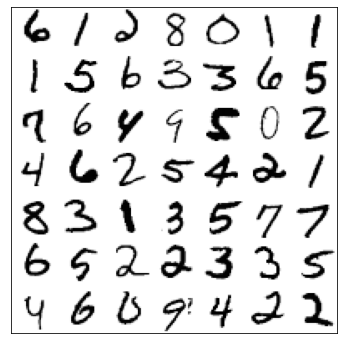

In [10]:
def print_images(x, ax, n=7, d=28, color='black'):
    ax.cla()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    panel = np.zeros([n*d,n*d])
    for i in range(n):
        for j in range(n):
            panel[i*d:(i+1)*d,j*d:(j+1)*d] = x[i*n+j,0]
            
    ax.imshow(panel, cmap=plt.get_cmap('Greys'))
    plt.setp(ax.spines.values(), color=color)

fig, ax = plt.subplots(figsize=(6,6))
            
for i, (x, y) in enumerate(train_loader):
    print_images(x, ax)
    break

In [11]:
g = models.GaussianVAEDecoder(capacity=128, depth=51).cuda()
f = models.VAEEncoder(capacity=128, depth=51).cuda()
loss_func = losses.gaussian_elbo

loss_r = []
loss_d = []
loss_train = []
loss_test = []

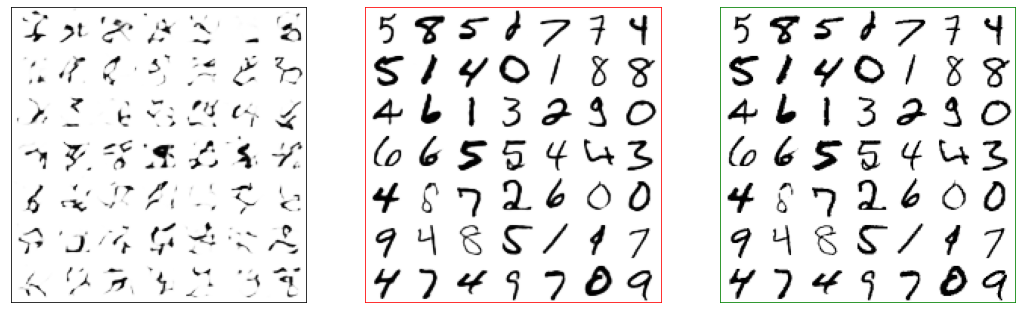

11400 63.38371157646179 70717.42 80060.135


100%|██████████| 20/20 [20:56<00:00, 62.83s/it]


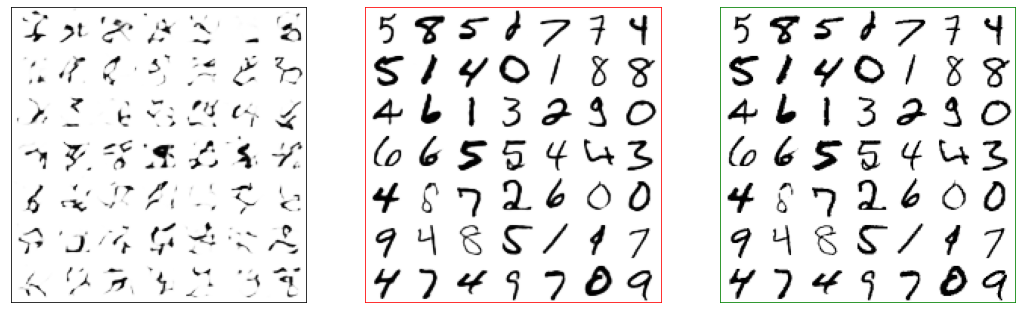

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(10,18))
fig.set_figwidth(18)

sigma = .03

optimizer = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr=3e-4)
i = 0
t0 = time()
for epoch in tqdm(range(20)):
    for x,_ in train_loader:
        x = x.cuda()
        
        optimizer.zero_grad()
        epsilon = torch.randn(x.shape[0],1,7,7).cuda()
        z, _, mu, logvar = f(x, epsilon)
        
        recon,div = loss_func(g(z),x,z,sigma,mu,logvar)
        loss = recon + div
        
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss.detach().cpu().numpy())
        loss_r.append(recon.detach().cpu().numpy())
        loss_d.append(div.detach().cpu().numpy())
        
        if i % 600 == 0:
            g.eval(); f.eval()
            #fake = g.sample(torch.randn(batch_size, 49).cuda(), sigma)
            fake = g(torch.randn(batch_size, 49).cuda()) # report the mean
            display.clear_output(wait=True)
            print_images(fake.detach().cpu(), ax[0], color='black')
            print_images(x.cpu(), ax[2], color='green')
            #print_images(g.sample(z, sigma).detach().cpu(), ax[1], color='red')
            print_images(g(z).detach().cpu(), ax[1], color='red') # report the mean
            display.display(plt.gcf())
            losst = 0
            for x,_ in test_loader:
                x = x.cuda()
                epsilon = torch.randn(x.shape[0],1,7,7).cuda()
                z, _, mu, logvar = f(x, epsilon)
                
                recont,divt = loss_func(g(z),x,z,sigma,mu,logvar)
                losst += recont.detach() + divt.detach()

            losst = losst.cpu().numpy() / len(test_loader)
            print(i,time()-t0,loss_train[-1],losst)
            t0 = time()
            g.train(); f.train()
        loss_test.append(losst)
        i += 1

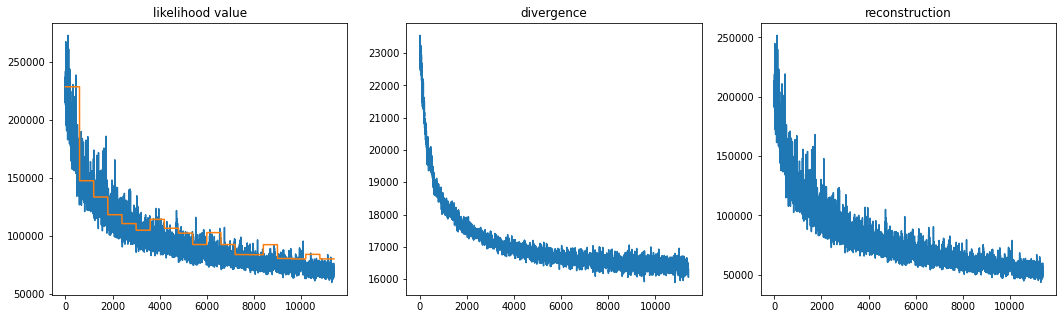

In [13]:
start = 600
end = -1

fig, axes = plt.subplots(1,3)
fig.set_figwidth(18)
fig.set_figheight(5)

axes[0].set_title('likelihood value')
axes[0].plot(loss_train[start:end])
axes[0].plot(loss_test[start:end])
axes[1].set_title('divergence')
axes[1].plot(loss_d[start:end])
axes[2].set_title('reconstruction')
axes[2].plot(loss_r[start:end])